In [62]:
# After performing a set of modifications to a notebook, 
# save the browser console logs to a file and insert it here. 
perf_log_file = "logs/simple-log.log"

In [63]:
from dataclasses import dataclass, field
from copy import copy
import matplotlib.pyplot as plt
import numpy as np

In [64]:

# Type definitions: 
CellID = str
TimeStampMS = float

# Life cycle of a rerun. 
# This represents a rerun segment in the log file. 
# 
# PERF T0: Rerun is started
# PERF T1: Kernel receives message to run first cell
#     At this point, all the rerun logic has finished.
#     Any remaining time is up to the kernel => Firsst cell scheduled. 
# PERF T2: Last reran cells have finished running 
#           => Immediately onExectued 
# PERF T3: Rerun reports that all cells have finished running 
#           => Has some overhead with set checking. 
# For the sake of just calcuating overhead, we should just use T1 - T0. 
@dataclass
class RerunPerfStat:
    rerun_start_time: TimeStampMS = None # T0
    rerun_end_time: TimeStampMS = None # T3
    first_cell_schedule_time: TimeStampMS = float('inf') # T1
    last_cell_executed_time: TimeStampMS = -float('inf') # T2

    # reran_cells is used to identify which cell execution events are part
    # of this rerun based on the cell IDs stored by the prints. 
    reran_cells: list[CellID] = field(default_factory=list)

class PerfStat:
    PERF_LINE_DELIM = "|"
    
    def __init__(self, file_path: str) -> None:
        """
        Upon creation, PerfStat parses the input file
        and generates the RerunPerfStats for further use.
        """
        self._cell_scheduled_times = []
        self._cell_executed_times = []

        self._rerun_stats = [] # Holds all rerunPerfStats for the entire log file. 

        # Two stage parsing process
        # First _parse() populates _cell_scheduled_times, _cell_executed_times
        # and _rerun_stats (effectively divids log file up into unique reran events). 
        self._parse(file_path)
        # Then _match_cells_to_reruns sets the first_cell_schedule_time (T1)
        # and last_cell_executed_time (T2) fields for each rerun found
        # by _parse. 
        self._match_cells_to_reruns()

    @staticmethod
    def _parse_cell_event(tokens: list[str]) -> tuple[CellID, TimeStampMS]:
        """
        There are two cell events:
         -Scheduled: occurs when the kernel recieves the request
                     to queue a cell for execution. 
         -Executed: emitted by the kernel once a cell has finished. 
         
        The perf messages for cell events follow the format of
        PERF|<Event> time=...|exec id=...|cell_id_token=...
        """
        time_token, _, cell_id_token = tokens
        _, timestamp = time_token.split("=")
        _, cell_id = cell_id_token.split("=")

        return cell_id, float(timestamp)

    def _handle_perf_line(self, line: str) -> None:
        """
        Given a raw perf log line, parses it based on the perf event
        and updates the parser datastructures. 
        """
        # First token is always PERF, skip
        tokens = line.split(self.PERF_LINE_DELIM)[1:] # => Scheduled time=...|exec id=...|cell_id_token=...
        
        event_name_token = tokens[0] # Scheduled time
        name, value = event_name_token.split("=") # => Scheduled time, TIME 
        if name == "Scheduled time":
            # Scheduled time=%f|exec id=%d|cell id=%s
            # NOTE: We may have other cells not having to do with reran here. 
            cell_id, timestamp = self._parse_cell_event(tokens)
            self._cell_scheduled_times.append((cell_id.strip(), timestamp)) # add to all cell scheduled time 
            
        elif name == "Executed time":
            # Executed time=%f|exec_id=%d|cell_id=%s
            # NOTE: We may have other cells not having to do with reran here. 
            cell_id, timestamp = self._parse_cell_event(tokens)
            self._cell_executed_times.append((cell_id.strip(), timestamp)) # add to all cell executed time
            
        elif name == "Rerun start":
            # Rerun start=%d|Rerun cells=%s
            rerun_stat = RerunPerfStat() # Create a new representation of a rerun event (segment). 
            rerun_stat.rerun_start_time = float(value)
            _, rerun_cell_tokens = tokens[1].split("=") # Get cells reran. 
            print("RERUN CELL TOKENS: ", [rerun_cell_tokens.strip()])
            clean_rerun_cell_tokens = rerun_cell_tokens.strip()
            if not clean_rerun_cell_tokens: 
                return 
            rerun_stat.reran_cells = [cell_id.strip() for cell_id in clean_rerun_cell_tokens.split(',')]
            if (len(rerun_stat.reran_cells) == 0):
                return 
            self._rerun_stats.append(rerun_stat)
            
        elif name == "Rerun end":
            # Rerun end=%f
            # This one is the rerun end time that has a little bit overhead. 
            latest_rerun = self._rerun_stats[-1] # Get the latest reran object. 
            latest_rerun.rerun_end_time = float(value) # Set their end time => this marks the end of a rerun segment.  

        else:
            raise ValueError(f"Invalid perf event: {line}")
        
    def _parse(self, file_path: str) -> None:
        """
        Iterates over each line of the log file 
        for perf events
        """
        with open(file_path) as fd:
            for line in fd:
                line_start_idx = line.find("PERF")
                if line_start_idx != -1:
                    print(line)
                    self._handle_perf_line(line[line_start_idx:])

    def _match_cell_start(self, cur_rerun: RerunPerfStat):
        """
        Iterates through the list of Scheduled events (scheduled_times)
        to find the Schedule event time of each reran cell in
        cur_rerun.
        
        First cell to be scheduled for rerun: 
        Sets the first_cell_schedule_time using the
        earliest Schedule event timestamp of reran cells. 
        """
        to_remove_idx = []
        reran_cells = set(cur_rerun.reran_cells)
        for idx, (cell_id, timestamp) in enumerate(self._cell_scheduled_times):
            if not reran_cells:
                break
            
            # Time is organized top (recent) -> bottom (past)
            if cell_id in reran_cells and timestamp >= cur_rerun.rerun_start_time:
                reran_cells.remove(cell_id)
                cur_rerun.first_cell_schedule_time = min(
                    cur_rerun.first_cell_schedule_time, timestamp
                )
                to_remove_idx.append(idx)
        
        # Remove all of this rerun segment cell's on schedule time since 
        # we already got the first scheduled cell's time. 
        self._cell_scheduled_times = [
            cell for idx, cell in enumerate(self._cell_scheduled_times) if idx not in to_remove_idx
        ]

    def _match_cell_end(self, cur_rerun: RerunPerfStat):
        """
        Iterates through the list of Executed events
        to find the Executed event time of each reran cell in
        cur_rerun.
        
        Sets the last_cell_executed_time using the
        latest Exexcuted event timestamp of reran cells
        """
        to_remove_idx = []
        reran_cells = set(cur_rerun.reran_cells)
        for idx, (cell_id, timestamp) in enumerate(self._cell_executed_times):
            if not reran_cells:
                break
            
            # All seen executed times will for sure be part of our rerun. 
            # Which means that they are the cells that got reran for this 
            # segment of the log file. 
            if cell_id in reran_cells:
                reran_cells.remove(cell_id)
                cur_rerun.last_cell_executed_time = max(
                    cur_rerun.last_cell_executed_time, timestamp
                )
                to_remove_idx.append(idx)

        # Remove all cells related to this rerun segment since we are done 
        # with it (extracted the last cell executed time). 
        self._cell_executed_times = [
            cell for idx, cell in enumerate(self._cell_executed_times) if idx not in to_remove_idx
        ]
        
    def _match_cells_to_reruns(self):
        """
        For each rerun, match cell events to the rerun the
        event was part of.
        """

        # the earliest reruns are at the beginning of _rerun_stats list
        # reverse the list so the earliest events are at the end
        # then we pop the events off the end until rerun_queue is empty
        rerun_queue = copy(self._rerun_stats)
        rerun_queue.reverse()
        
        while rerun_queue:
            cur_rerun = rerun_queue.pop()
            self._match_cell_start(cur_rerun)
            self._match_cell_end(cur_rerun)

    @property
    def rerun_perf_stats(self) -> list[RerunPerfStat]:
        """ Public getter method to use the rerun stats for analysis. """
        return self._rerun_stats

    def pretty_print_rerun_stats(self) -> None:
        """ Formatted print of all rerun stats, cell ids are excluded. """
        out_msg = ["Reruns:"]
        for idx, rerun in enumerate(self._rerun_stats):
            rerun_msg = (
                f"Rerun idx: {idx}\n"
                f"Number of cells reran: {len(rerun.reran_cells)}\n"
                f"Rerun start timestamp: {rerun.rerun_start_time}ms\n"
                f"First cell scheduled timestamp: {rerun.first_cell_schedule_time}ms\n"
                f"Last cell executed timestamp: {rerun.last_cell_executed_time}ms\n"
                f"Rerun end timestamp: {rerun.rerun_end_time}ms\n"
            )
            out_msg.append(rerun_msg)
        print("\n".join(out_msg))

    def average_overhead(self) -> dict[int, list[float, int]]:
        """
        Returns a dict
        num cells in rerun -> average overhead of rerun in ms, num reruns. 
        see how rerun overhead changes as we get more cells that we need to rerun. 
        """
        ret = {}
        for rerun in self._rerun_stats:
            n_cells = len(rerun.reran_cells)
            overhead = rerun.first_cell_schedule_time - rerun.rerun_start_time
            if info := ret.get(n_cells):
                info[0] += overhead
                info[1] += 1 # accumulate reruns with this exact num of cells to rerun. 
            else:
                ret[n_cells] = [overhead, 1]

        return ret
    

In [65]:
stat = PerfStat(perf_log_file)

log.ts:3 PERF|Scheduled time=227609.69999998808|exec id=3|cell id=873cf675-d529-452c-a8ff-1053d33f8eae

log.ts:3 PERF|Rerun start=227609|Rerun cells=873cf675-d529-452c-a8ff-1053d33f8eae

RERUN CELL TOKENS:  ['873cf675-d529-452c-a8ff-1053d33f8eae']
log.ts:3 PERF|Executed time=227622.59999999404|exec_id=5|cell_id=873cf675-d529-452c-a8ff-1053d33f8eae

log.ts:3 PERF|Rerun end=227622.69999998808

log.ts:3 PERF|Scheduled time=232665.09999999404|exec id=1|cell id=d051048c-fcee-462a-aff4-c0f2e38830b8

log.ts:3 PERF|Executed time=232690.5|exec_id=6|cell_id=d051048c-fcee-462a-aff4-c0f2e38830b8

log.ts:3 PERF|Scheduled time=232691.29999999702|exec id=4|cell id=7c32c6a2-28cc-4f19-b92c-43266d1560d1

log.ts:3 PERF|Scheduled time=232693|exec id=5|cell id=873cf675-d529-452c-a8ff-1053d33f8eae

log.ts:3 PERF|Rerun start=232690|Rerun cells=7c32c6a2-28cc-4f19-b92c-43266d1560d1,873cf675-d529-452c-a8ff-1053d33f8eae

RERUN CELL TOKENS:  ['7c32c6a2-28cc-4f19-b92c-43266d1560d1,873cf675-d529-452c-a8ff-1053d33f8

In [66]:
stat.pretty_print_rerun_stats()

Reruns:
Rerun idx: 0
Number of cells reran: 1
Rerun start timestamp: 227609.0ms
First cell scheduled timestamp: 227609.69999998808ms
Last cell executed timestamp: 227622.59999999404ms
Rerun end timestamp: 227622.69999998808ms

Rerun idx: 1
Number of cells reran: 2
Rerun start timestamp: 232690.0ms
First cell scheduled timestamp: 232691.29999999702ms
Last cell executed timestamp: 232718.69999998808ms
Rerun end timestamp: 232718.79999999702ms

Rerun idx: 2
Number of cells reran: 3
Rerun start timestamp: 248154.0ms
First cell scheduled timestamp: 248155.39999999106ms
Last cell executed timestamp: 248183.29999999702ms
Rerun end timestamp: 248199.0ms



In [67]:
print(stat.average_overhead())

{1: [0.699999988079071, 1], 2: [1.2999999970197678, 1], 3: [1.3999999910593033, 1]}


In [68]:
def plot_average_runtime_chart(rerun: RerunPerfStat) -> None:
    processes = [
        {
            "name": "Handling Rerun Signal",
            "start": 0,
            "stop": rerun.first_cell_schedule_time - rerun.rerun_start_time,
        }, 
        {
            "name": "Cells executing (Rerun)",
            "start": rerun.first_cell_schedule_time - rerun.rerun_start_time,
            "stop": rerun.rerun_end_time - rerun.rerun_start_time,
        },
    ]

    process_names = [p["name"] for p in processes]
    start_times = [p["start"] for p in processes]
    durations = [p["stop"] - p["start"] for p in processes]
    y_positions = np.arange(len(processes))
    
    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    
    # Plot horizontal bars (Gantt chart)
    plt.barh(y_positions, durations, left=start_times, height=0.4, color='skyblue', edgecolor='black')
    
    # Customize the plot
    plt.yticks(y_positions, process_names)
    plt.xlabel('Time (milliseconds)')
    plt.ylabel('Processes')
    plt.title('Process Latency (Start and Stop Times)')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent label clipping
    plt.tight_layout()

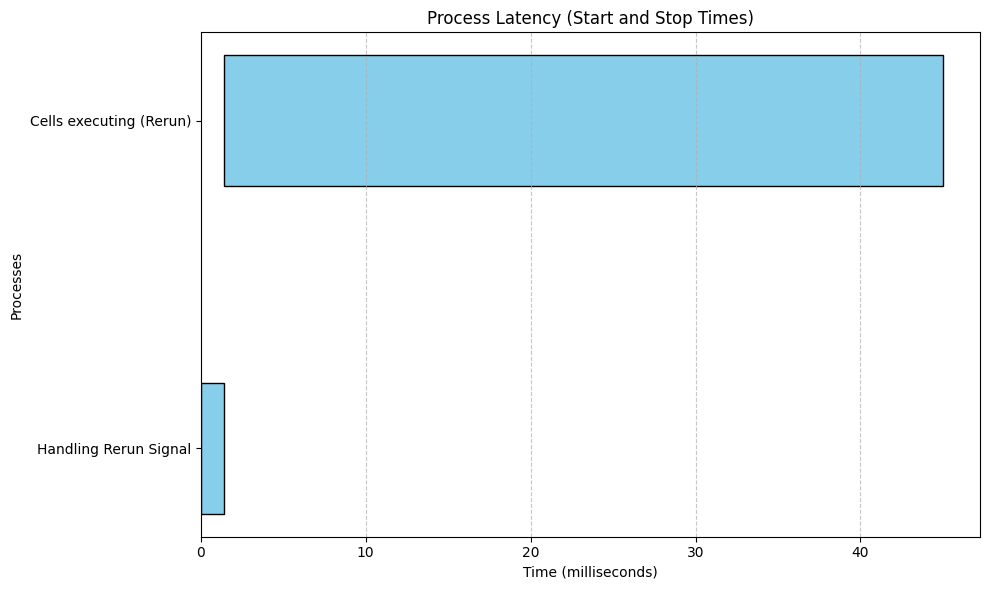

In [69]:
plot_average_runtime_chart(stat.rerun_perf_stats[-1])